In [1]:
%who

Interactive namespace is empty.


In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib
import seaborn as sns

# # getting the spatial plotting function from another directory
# import sys
# new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
# if new_path not in sys.path:
#     sys.path.append(new_path)
# import validation_functions as myfuncs
# %run -i drought_2017to2019/dataInfo_and_functions.py

import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#### NSW also contains data for the period post 2010

# subsetted gauges by basins and saved in csv files. Reading them in  
filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_darling.csv'
df_darling = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_Murrum.csv'  #Murrumbidgee & Upper Murray
df_murrum = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_Gwydir.csv'
df_gwydir = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_Lachlan.csv'
df_lachlan = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_hunter.csv'  #Hunter & Namoi
df_hunter = pd.read_csv(filename)

### Excluded wells QLD

hydroid = 40133180, 40134998, 40147832

Three wells in QLD have partial data covering the first two years of the drought. These wells have been exluded from the calculation of seasonal average deficits to obtain consistent estimates of mean changes in water levels throughout the drought period.
Two of these wells show large water depth anomalies 3-5 m on average.

In [5]:
# Only NSW has relevant data (post 1996)
# QLD has data post 2010

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_80perc_post2010_longrec.nc'
ds_gw = xr.open_dataset(filename)
ds_gw.load()
# baseline = slice('2010-01-01', None)
baseline = slice('2010-01-01', '2016-12-31')  # the agreed shorter baseline
drought_time = slice('2016-01-01', '2020-12-31')
vname = 'result'
da_mon = ds_gw[vname].resample(time = '1M').mean()
# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = drought_time).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

lat_val = np.round(ds_gw['Latitude'].mean(['time', 'obs_point_datum']).values, 3)
lon_val = np.round(ds_gw['Longitude'].mean(['time', 'obs_point_datum']).values, 3)
hydroid = ds_gw.hydroid.values
clim = np.round(da_lt_monClim.mean(['month', 'obs_point_datum']).values, 3)
df_gw_latlon = pd.DataFrame({'lat': lat_val, 'lon': lon_val, 'hydroid': hydroid, 'clim': clim})
#df_gw_latlon.head()

#################################################
# did not get rid of duplicates here because I'm subsetting by non-duplicate hydroids for each basin/reg later
#################################################

# print("How many duplicates are there?")
# print(sum(df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim'])))

# df_latlon_duplicates = df_gw_latlon.groupby(df_gw_latlon[['lat', 'lon', 'clim']].columns.tolist(),as_index=False).size()
# df_latlon_duplicates = df_latlon_duplicates[df_latlon_duplicates['size']>1]
# dup_hydroids = df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim']).values

da_NSW_lt_monClim_post2010 = da_lt_monClim#.isel(hydroid = ~dup_hydroids)
da_NSW_monAnom_post2010 = da_monAnom#.isel(hydroid = ~dup_hydroids)


filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW.nc'
ds_gw = xr.open_dataset(filename)
ds_gw.load()
# baseline = slice('1996-01-01', None)
baseline = slice('1996-01-01', '2016-12-31')
drought_time = slice('2016-01-01', '2020-12-31')
vname = 'result'
da_mon = ds_gw[vname].resample(time = '1M').mean()
# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = drought_time).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

lat_val = np.round(ds_gw['Latitude'].mean(['time', 'obs_point_datum']).values, 3)
lon_val = np.round(ds_gw['Longitude'].mean(['time', 'obs_point_datum']).values, 3)
hydroid = ds_gw.hydroid.values
clim = np.round(da_lt_monClim.mean(['month', 'obs_point_datum']).values, 3)
df_gw_latlon = pd.DataFrame({'lat': lat_val, 'lon': lon_val, 'hydroid': hydroid, 'clim': clim})
#df_gw_latlon.head()

print("How many duplicates are there?")
print(sum(df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim'])))

df_latlon_duplicates = df_gw_latlon.groupby(df_gw_latlon[['lat', 'lon', 'clim']].columns.tolist(),as_index=False).size()
df_latlon_duplicates = df_latlon_duplicates[df_latlon_duplicates['size']>1]
dup_hydroids = df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim']).values

da_NSW_lt_monClim = da_lt_monClim.isel(hydroid = ~dup_hydroids)
da_NSW_monAnom = da_monAnom.isel(hydroid = ~dup_hydroids)


filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_QLD_80perc_post2010_longrec.nc'
ds_gw = xr.open_dataset(filename)
ds_gw.load()

# QLD: Don't know what is going on with hydroid = 40136254 as WL is steadily decreasing from 2010, so excluding this well
bool_hydroid = ~(ds_gw.hydroid.values == 40136254)
ds_gw = ds_gw.isel(hydroid = bool_hydroid)
# baseline = slice('2010-01-01', None)
baseline = slice('2010-01-01', '2016-12-31')
drought_time = slice('2016-01-01', '2020-12-31')
vname = 'result'
da_mon = ds_gw[vname].resample(time = '1M').mean()
# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = drought_time).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

inclWells = da_monAnom.count('time').max('obs_point_datum').values >= 36
da_QLD_lt_monClim = da_lt_monClim.isel(hydroid = inclWells)
da_QLD_monAnom = da_monAnom.isel(hydroid = inclWells)

How many duplicates are there?
38


### Line & bar plots of anomalies in smaller sub-regions

In [9]:
import matplotlib
fig_dir = 'figures/drought_2017to2020/borewell/'

data_names = ['Condamine', # (baseline = 201001 to 202109)',
              'Gwydir', # (baseline = 201001 to 202109)',
              'Hunter & Namoi', # (baseline = 201001 to 202109)',
              'Lachlan', # (baseline = 201001 to 202109)',
              'Darling (longer record)', # (baseline = 199601 to 202109)',
              'Darling', #(baseline = 201001 to 202109)'
              'Murrumbidgee & Upper Murray'] # (baseline = 201001 to 202109)',

time_sel = slice('2016-01-01', '2020-12-31')
              
########
# NSW
########

hydroids_noDTW_NSW = da_NSW_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_NSW = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[~hydroids_noDTW_NSW]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[hydroids_noDTW_NSW]]
data_list_NSW.extend(data_list_swl)

da_NSW_anom_all = xr.concat(data_list_NSW, dim = 'wells')
da_NSW_anom_mean = da_NSW_anom_all.sel(time = time_sel).mean('wells')

########
# QLD
########

hydroids_noDTW_QLD = da_QLD_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_QLD = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[~hydroids_noDTW_QLD]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[hydroids_noDTW_QLD]]
data_list_QLD.extend(data_list_swl)

da_QLD_anom_all = xr.concat(data_list_QLD, dim = 'wells')
da_QLD_anom_mean = da_QLD_anom_all.sel(time = time_sel).mean('wells')


####################
# NSW post 2010
####################

list_point_subsets = [df_gwydir['hydroid'].values, df_hunter['hydroid'].values, df_lachlan['hydroid'].values, 
                      df_darling['hydroid'].values, df_murrum['hydroid'].values]
list_anom_mean = []
for point_set in list_point_subsets:
    hydroids_noDTW = da_NSW_lt_monClim_post2010.sel(hydroid = point_set, obs_point_datum = 'DTW').count('month').values == 0

    datum_sel = 'DTW'
    data_list = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    # add SWL measurements for wells where the DTW measurements are unavailable
    datum_sel = 'SWL'
    data_list_swl = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    data_list.extend(data_list_swl)
    da_reg_anom_all = xr.concat(data_list, dim = 'wells')
    da_reg_anom_mean = da_reg_anom_all.sel(time = time_sel).mean('wells')
    list_anom_mean.append(da_reg_anom_mean)
    
import seaborn as sns
nBasins = len(list_point_subsets)+2
col_sel = sns.color_palette("icefire", nBasins)
col_sel[2] = 'green'

list_for_plot = [da_QLD_anom_mean]
list_for_plot.extend(list_anom_mean[0:-2])  # All regions except Darling short record, Murrumbidgee
list_for_plot.extend([da_NSW_anom_mean])    # Darling long record
list_for_plot.extend(list_anom_mean[-2::])    # Darling short record & Murrumbidgee

In [7]:
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

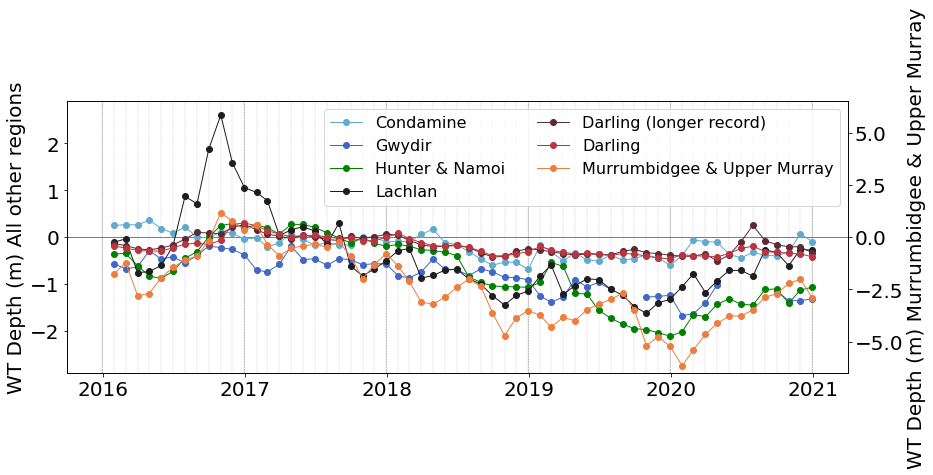

In [10]:
#######
# PLOT
#######

fig_dir = 'figures/drought_2017to2020/timeseries_plots/'

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

mon_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

for xline in mon_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

for data, col, label in zip(list_for_plot, col_sel, data_names):
    if label == 'Murrumbidgee & Upper Murray':
        ax2 = ax.twinx()
        ax_sel = ax2
    else:
        ax_sel = ax
        
    ax_sel.plot(data.time.values, data.values*-1, marker='o', color=col, linewidth=1, zorder=10, label = label)
    
    #******** removed the bars on the plot
    #xx = data.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    #array_time = [x.astype('datetime64[D]') for x in xx]
    #array_val = data.resample(time="QS-DEC").mean().values*-1
    #ax_sel.bar(array_time[1:-1], array_val[1:-1], width=90, edgecolor='white', color=col, alpha=0.2, zorder=5) #, label = label)
    #ax_sel.bar(array_time, array_val, width=85, edgecolor=col, zorder=5, fill=False)

plt.xlabel('')

ax.set_ylabel('WT Depth (m) All other regions')
ax2.set_ylabel('WT Depth (m) Murrumbidgee & Upper Murray')

ax.set_ylim((-2.9, 2.9))
ax2.set_ylim((-6.5, 6.5))

from matplotlib.lines import Line2D
legend_elements = []
for name, col in zip(data_names, col_sel):
    legend_elements.append(Line2D([0], [0], color=col, lw=1, marker="o",label=name))
ax2.legend(handles=legend_elements, ncol=2, loc=0)

fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine.png', bbox_inches='tight', dpi = 300)
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine.pdf', bbox_inches='tight', format = 'pdf')

### Plot of anomalies from 2010 to 2021
I've plotted 'depth to the water table' below. Positive values indicate deeper WT.

In [20]:
import matplotlib
fig_dir = 'figures/drought_2017to2020/borewell/'

data_names = ['Condamine', # (baseline = 201001 to 202109)',
              'Gwydir', # (baseline = 201001 to 202109)',
              'Hunter & Namoi', # (baseline = 201001 to 202109)',
              'Lachlan', # (baseline = 201001 to 202109)',
              'Murrumbidgee & Murray', # (baseline = 201001 to 202109)',
              'Darling (longer Record)', # (baseline = 199601 to 202109)',
              'Darling'] #(baseline = 201001 to 202109)']

time_sel = slice('2010-01-01', None)
    
########
# NSW
########

hydroids_noDTW_NSW = da_NSW_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_NSW = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[~hydroids_noDTW_NSW]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[hydroids_noDTW_NSW]]
data_list_NSW.extend(data_list_swl)

da_NSW_anom_all = xr.concat(data_list_NSW, dim = 'wells')
da_NSW_anom_mean = da_NSW_anom_all.sel(time = time_sel).mean('wells')

########
# QLD
########

hydroids_noDTW_QLD = da_QLD_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_QLD = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[~hydroids_noDTW_QLD]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[hydroids_noDTW_QLD]]
data_list_QLD.extend(data_list_swl)

da_QLD_anom_all = xr.concat(data_list_QLD, dim = 'wells')
da_QLD_anom_mean = da_QLD_anom_all.sel(time = time_sel).mean('wells')


####################
# NSW post 2010
####################

list_point_subsets = [df_gwydir['hydroid'].values, df_hunter['hydroid'].values, df_lachlan['hydroid'].values, 
                      df_murrum['hydroid'].values, df_darling['hydroid'].values]
list_anom_mean = []
for point_set in list_point_subsets:
    hydroids_noDTW = da_NSW_lt_monClim_post2010.sel(hydroid = point_set, obs_point_datum = 'DTW').count('month').values == 0

    datum_sel = 'DTW'
    data_list = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    # add SWL measurements for wells where the DTW measurements are unavailable
    datum_sel = 'SWL'
    data_list_swl = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    data_list.extend(data_list_swl)
    da_reg_anom_all = xr.concat(data_list, dim = 'wells')
    da_reg_anom_mean = da_reg_anom_all.sel(time = time_sel).mean('wells')
    list_anom_mean.append(da_reg_anom_mean)
    
import seaborn as sns
nBasins = len(list_point_subsets)+2
col_sel = sns.color_palette("icefire", nBasins)

list_for_plot = [da_QLD_anom_mean]
list_for_plot.extend(list_anom_mean)
list_for_plot.extend([da_NSW_anom_mean])

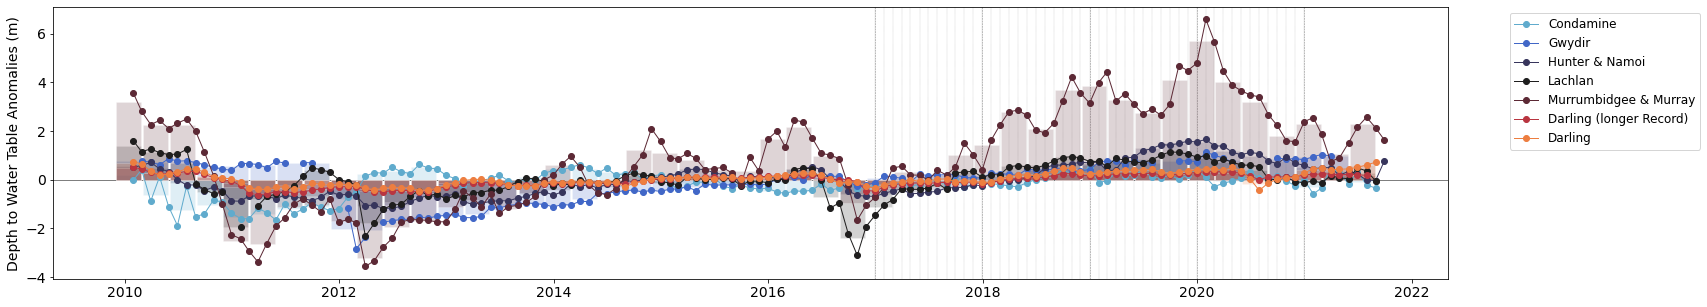

In [22]:
#######
# PLOT
#######

# col_NSW = 'blue'
# col_QLD = 'darkorange'

# list_anom_mean_all = 

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(25,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
# # for da, color in zip(data_list, col_sel):
# for da in data_list_NSW:
#     plt.plot(da.time.values - np.timedelta64(20, 'D'), da.values, marker='o', color=col_NSW, label=None, linewidth=0, markersize=1.5, zorder=10)
    
# for da in data_list_QLD:
#     plt.plot(da.time.values - np.timedelta64(10, 'D'), da.values, marker='^', color=col_QLD, label=None, linewidth=0, markersize=2, zorder=10) #, edgecolors='black')

for data, col, label in zip(list_for_plot, col_sel, data_names):
    plt.plot(data.time.values, data.values, marker='o', color=col, linewidth=1, zorder=10, label = label)
    xx = data.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = data.resample(time="QS-DEC").mean().values
    plt.bar(array_time[0:-1], array_val[0:-1], width=85, edgecolor='white', color=col, alpha=0.2, zorder=5) #, label = label)

# plt.plot(da_NSW_anom_mean.time.values, da_NSW_anom_mean.values, marker='o', color=col_NSW, label=None, linewidth=1, zorder=10)
# plt.plot(da_QLD_anom_mean.time.values, da_QLD_anom_mean.values, marker='o', color=col_QLD, label=None, linewidth=1, zorder=10) #, edgecolors='black')

# xx = da_NSW_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
# array_time = [x.astype('datetime64[D]') for x in xx]
# array_val_NSW = da_NSW_anom_mean.resample(time="QS-DEC").mean().values
# plt.bar(array_time[0:-1], array_val_NSW[0:-1], width=85, edgecolor='white', color=col_NSW, alpha=0.2, zorder=5, label = 'southwest NSW')

# xx = da_QLD_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
# array_time = [x.astype('datetime64[D]') for x in xx]
# array_val_QLD = da_QLD_anom_mean.resample(time="QS-DEC").mean().values
# plt.bar(array_time[0:-1], array_val_QLD[0:-1], width=85, edgecolor='white', color=col_QLD, alpha=0.35, zorder=5, label = 'southeast QLD')

#bp = plt.boxplot(da_anom_all.values, positions=matplotlib.dates.date2num(da_anom_all.time.values), sym='.', widths=0.12, patch_artist=True) #, notch = True)
#myfuncs.set_box_color(bp, 'blue')

plt.xlabel('')
plt.ylabel('Depth to Water Table Anomalies (m)')
# plt.title(ref_title)
#plt.ylim((-1, 1))
plt.legend(loc="upper left", bbox_to_anchor=(1.04,1))
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine_post2010.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine_post2010.pdf', bbox_inches='tight', format = 'pdf')

### Anomalies in m (to mention in the text)

In [17]:
df_anom = pd.DataFrame(dict(zip(data_names, [np.round(da.resample(time="QS-DEC").mean(), 5).values*-1 for da in list_for_plot])))
                       #  'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       # 'climatology (mm)': np.round(clim_seasMean, 5).values})
df_anom['time'] = list_for_plot[0].resample(time="QS-DEC").mean().time.values
df_anom = df_anom.set_index('time')
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_borewell_level_anomalies_moreData.csv'
df_anom.to_csv(out_file)

            Condamine   Gwydir  Hunter & Namoi  Lachlan  \
time                                                      
2015-12-01    0.25789 -0.62416        -0.35208 -0.07384   
2016-03-01    0.26875 -0.46468        -0.77423 -0.69902   
2016-06-01    0.10085 -0.45493        -0.49632  0.46378   
2016-09-01    0.06050 -0.22683         0.18073  2.02118   
2016-12-01   -0.09111 -0.60793         0.21967  0.92955   
2017-03-01   -0.02840 -0.41703         0.20163  0.13587   
2017-06-01   -0.15251 -0.50828         0.09380  0.09053   
2017-09-01   -0.05458 -0.54585        -0.08878 -0.70803   
2017-12-01   -0.09867 -0.75902        -0.18140 -0.34345   
2018-03-01    0.03582 -0.63207        -0.29363 -0.79886   
2018-06-01   -0.31250 -0.72993        -0.73691 -0.85989   
2018-09-01   -0.55702 -0.82084        -1.05314 -1.31484   
2018-12-01   -0.38756 -1.18719        -0.85933 -0.85781   
2019-03-01   -0.44459 -1.08113        -1.01316 -1.05037   
2019-06-01   -0.46223 -1.04186        -1.71534 -1.08570 

In [18]:
df_anom = pd.DataFrame(dict(zip(data_names, [np.round(da, 5).values*-1 for da in list_for_plot])))
                       #  'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       # 'climatology (mm)': np.round(clim_seasMean, 5).values})
df_anom['time'] = list_for_plot[0].time.values
df_anom = df_anom.set_index('time')
print(df_anom)

out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/mon_borewell_level_anomalies_moreData.csv'
df_anom.to_csv(out_file_mon)

            Condamine   Gwydir  Hunter & Namoi  Lachlan  \
time                                                      
2016-01-31    0.24970 -0.57334        -0.35587 -0.11079   
2016-02-29    0.26609 -0.67498        -0.34828 -0.03690   
2016-03-31    0.26167 -0.63711        -0.60799 -0.75982   
2016-04-30    0.36183 -0.28847        -0.83245 -0.73374   
2016-05-31    0.18273 -0.46848        -0.88224 -0.60349   
2016-06-30    0.08349 -0.42030        -0.72729 -0.18891   
2016-07-31    0.21181 -0.55522        -0.45193  0.86915   
2016-08-31    0.00726 -0.38927        -0.30974  0.71109   
2016-09-30   -0.01679 -0.19242         0.00597  1.87462   
2016-10-31    0.11251 -0.22384         0.24578  2.60752   
2016-11-30    0.08578 -0.26422         0.29044  1.58139   
2016-12-31   -0.04636 -0.37852         0.20196  1.05616   
2017-01-31   -0.01498 -0.70302         0.25862  0.95469   
2017-02-28   -0.21200 -0.74225         0.19843  0.77781   
2017-03-31   -0.11722 -0.57647         0.06350  0.02921 